# Drift Model Testing

__Intended Process:__

- STEP 1: get stuff out of a data file

- UDD format data --> generate drift times (t1 - t0) then input into the equation to get drift radii (and uncertainties)
- use same data and get simulated radii from existing falaise
- plot radii versus each other to see how the models compare
- is there "truth data" for simulated data? (Ask Cheryl) -- see quantitatively how well Betsy's drift model works to estimate radius, get a quantitative result for how well it works compared to existing falaise

Next steps:  
- use real data as opposed to simulated
- quantify impact of implementing more detailed electric field
- track fitting?

Barriers to progress: 
- .brio format? Look at how Betsy got her data
    - used .root filed (can use Cheryl's code to convert)
- which pressure are we using again?

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time as tm

In [2]:
data = uproot.open('snemo_run-840_udd.root')

In [78]:
data['SimData;1'].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
header.runnumber     | int32_t                  | AsDtype('>i4')
header.eventnumber   | int32_t                  | AsDtype('>i4')
header.date          | int32_t                  | AsDtype('>i4')
header.runtype       | int32_t                  | AsDtype('>i4')
header.simulated     | bool                     | AsDtype('bool')
header.real          | bool                     | AsDtype('bool')
tracker.nohits       | int32_t                  | AsDtype('>i4')
tracker.id           | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
tracker.module       | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
tracker.side         | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
tracker.layer        | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
tracker.column       | std::vector<int32_t>     | AsJagge

In [69]:
# testing values of variables
# 0 not picked for a particular reason -- times should be so close together that it's below uncertainty levels
trigger_times = data['SimData;1']['digicalo.timestamp'].array(library='np')[0]
trigger_times[0]

adjustment = data['SimData;1']['digicalo.lttimecounter'].array(library='np')[0]

In [75]:
data['SimData;1']['digicalo.lttriggercounter'].array(library='np')[0]

array([232, 286], dtype=uint16)

In [175]:
test_list = []

timestamp_1 = data['SimData;1']['digitracker.side'].array(library='np')[0]

test_list.extend(np.array(timestamp_1, dtype='float').tolist())

In [177]:
timestamp_1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [176]:
new_list = [x for [x] in timestamp_1]

TypeError: cannot unpack non-iterable numpy.int32 object

In [170]:
test_ev_list = [3] *3

In [172]:
test_ev_list.extend(['n']*5)

In [173]:
test_ev_list

[3, 3, 3, 'n', 'n', 'n', 'n', 'n']

In [23]:
anode_times = data['SimData;1']['digitracker.anodetimestampR0'].array(library='np')[0]
anode_times_2 = data['SimData;1']['digitracker.anodetimestampR1'].array(library='np')[0]

In [73]:
# R0 conversion from clock ticks to us
(np.array(anode_times[0]).item() - (trigger_times[0] - adjustment[0])/2)*12.5*10**(-3)

37334.11875

In [118]:
id_branch = data['SimData;1']['digitracker.id'].array(library='np')
num_events = np.arange(len(id_branch))
test_events = np.arange(100)

In [178]:
# all values in event at once method

start = tm.time()
exceptions = []
verbose = True
event_nums = []
ids = []
sides = []
layers = []
columns = []
R0s = []
trigger_times = []


for n in test_events:
    id_list = np.array(id_branch[n], dtype='int')
    num_hits = len(id_list)
    
    ev_sides = data['SimData;1']['digitracker.side'].array(library='np')[n]
    ev_layers = data['SimData;1']['digitracker.layer'].array(library='np')[n]
    ev_columns = data['SimData;1']['digitracker.column'].array(library='np')[n]
    ev_R0s = data['SimData;1']['digitracker.anodetimestampR0'].array(library='np')[n]
    ev_ids = data['SimData;1']['digitracker.id'].array(library='np')[n]
    
    event_nums.extend([n] * num_hits)
    trigger_times.extend([data['SimData;1']['digicalo.timestamp'].array(library='np')[n][0]/2] * num_hits)
    
    sides.extend(ev_sides)
    layers.extend(ev_layers)
    columns.extend(ev_columns)
    R0s.extend([r for [r] in ev_R0s])
    ids.extend(ev_ids)
    
    if verbose is True:
        print(n + 1, 'of', len(test_events), 'complete')

end = tm.time()
print('Runtime:', (end - start)/60, 'minutes')

1 of 100 complete
2 of 100 complete
3 of 100 complete
4 of 100 complete
5 of 100 complete
6 of 100 complete
7 of 100 complete
8 of 100 complete
9 of 100 complete
10 of 100 complete
11 of 100 complete
12 of 100 complete
13 of 100 complete
14 of 100 complete
15 of 100 complete
16 of 100 complete
17 of 100 complete
18 of 100 complete
19 of 100 complete
20 of 100 complete
21 of 100 complete
22 of 100 complete
23 of 100 complete
24 of 100 complete
25 of 100 complete
26 of 100 complete
27 of 100 complete
28 of 100 complete
29 of 100 complete
30 of 100 complete
31 of 100 complete
32 of 100 complete
33 of 100 complete
34 of 100 complete
35 of 100 complete
36 of 100 complete
37 of 100 complete
38 of 100 complete
39 of 100 complete
40 of 100 complete
41 of 100 complete
42 of 100 complete
43 of 100 complete
44 of 100 complete
45 of 100 complete
46 of 100 complete
47 of 100 complete
48 of 100 complete
49 of 100 complete
50 of 100 complete
51 of 100 complete
52 of 100 complete
53 of 100 complete
54

In [179]:
event = pd.DataFrame(data={'Event':event_nums, 'ID':ids, 'Side':sides, 'Layer':layers, 'Column':columns, 'R0':R0s, 'Trigger_time':trigger_times})

event.head()

,Event,ID,Side,Layer,Column,R0,Trigger_time
0,0,0,1,0,7,847289447,847289131.5
1,0,1,1,8,0,847289127,847289131.5
2,0,2,1,5,3,847289197,847289131.5
3,0,3,1,6,2,847289122,847289131.5
4,0,4,1,1,7,847289281,847289131.5


In [ ]:
# pandas concat method

start = tm.time()
exceptions = []
verbose = True
events = pd.DataFrame(columns=['Event', 'ID', 'Side', 'Layer', 'Column', 'R0', 'R1'])

for n in test_events:
    id_list = np.array(id_branch[n], dtype='int')
    num_hits = np.arange(len(id_list))
    
    for k in num_hits: 
        try:
            side = np.array(data['SimData;1']['digitracker.side'].array(library='np')[n], dtype='bool')[k].item()
            layer = np.array(data['SimData;1']['digitracker.layer'].array(library='np')[n], dtype='int')[k].item()
            column = np.array(data['SimData;1']['digitracker.column'].array(library='np')[n], dtype='int')[k].item()
            R0 = np.array(data['SimData;1']['digitracker.anodetimestampR0'].array(library='np')[n], dtype='float')[k].item()
            R1 = np.array(data['SimData;1']['digitracker.anodetimestampR1'].array(library='np')[n], dtype='float')[k].item()
            id_var = id_list[k].item()

            event = pd.DataFrame(data={'Event':[n], 'ID':[id_var], 'Side':[side], 'Layer':[layer], 'Column':[column], 'R0':[R0], 'R1':[R1]})

            events = pd.concat([events, event], axis=0, ignore_index=True)
            
        except:
            exceptions.append((n, k))
    if verbose is True:
        print(n + 1, 'of', len(test_events), 'complete')

end = tm.time()
print('Runtime:', (end - start)/60, 'minutes')

1 of 100 complete
2 of 100 complete
3 of 100 complete
4 of 100 complete
5 of 100 complete
6 of 100 complete


In [28]:
# list method

In [76]:
# finding smallest calo timestamp

trigger_times = data['SimData;1']['digicalo.timestamp'].array(library='np')
len(trigger_times)

9590

In [119]:
start = tm.time()
exceptions = []
verbose = True
events = pd.DataFrame(columns=['Event', 'ID', 'Side', 'Layer', 'Column', 'R0', 'R1'])
event_nums = []
ids = []
sides = []
layers = []
columns = []
R0s = []
trigger_times = []


for n in test_events:
    id_list = np.array(id_branch[n], dtype='int')
    num_hits = np.arange(len(id_list))
    
    for k in num_hits: 
        try:
            sides.append(np.array(data['SimData;1']['digitracker.side'].array(library='np')[n], dtype='bool')[k].item())
            layers.append(np.array(data['SimData;1']['digitracker.layer'].array(library='np')[n], dtype='int')[k].item())
            columns.append(np.array(data['SimData;1']['digitracker.column'].array(library='np')[n], dtype='int')[k].item())
            R0s.append(np.array(data['SimData;1']['digitracker.anodetimestampR0'].array(library='np')[n], dtype='float')[k].item())
            ids.append(id_list[k].item())
            event_nums.append(n)
            trigger_times.append(data['SimData;1']['digicalo.timestamp'].array(library='np')[n][0]/2)
        except:
            exceptions.append((n, k))
    if verbose is True:
        print(n + 1, 'of', len(test_events), 'complete')

end = tm.time()
print('Runtime:', (end - start)/60, 'minutes')

1 of 100 complete
2 of 100 complete
3 of 100 complete
4 of 100 complete
5 of 100 complete
6 of 100 complete
7 of 100 complete
8 of 100 complete
9 of 100 complete
10 of 100 complete
11 of 100 complete
12 of 100 complete
13 of 100 complete
14 of 100 complete
15 of 100 complete
16 of 100 complete
17 of 100 complete
18 of 100 complete
19 of 100 complete
20 of 100 complete
21 of 100 complete
22 of 100 complete
23 of 100 complete
24 of 100 complete
25 of 100 complete
26 of 100 complete
27 of 100 complete
28 of 100 complete
29 of 100 complete
30 of 100 complete
31 of 100 complete
32 of 100 complete
33 of 100 complete
34 of 100 complete
35 of 100 complete
36 of 100 complete
37 of 100 complete
38 of 100 complete
39 of 100 complete
40 of 100 complete
41 of 100 complete
42 of 100 complete
43 of 100 complete
44 of 100 complete
45 of 100 complete
46 of 100 complete
47 of 100 complete
48 of 100 complete
49 of 100 complete
50 of 100 complete
51 of 100 complete
52 of 100 complete
53 of 100 complete
54

In [120]:
event = pd.DataFrame(data={'Event':event_nums, 'ID':ids, 'Side':sides, 'Layer':layers, 'Column':columns, 'R0':R0s, 'Trigger_time':trigger_times})

event.head()

,Event,ID,Side,Layer,Column,R0,Trigger_time
0,0,0,True,0,7,847289447.0,847289131.5
1,0,1,True,8,0,847289127.0,847289131.5
2,0,2,True,5,3,847289197.0,847289131.5
3,0,3,True,6,2,847289122.0,847289131.5
4,0,4,True,1,7,847289281.0,847289131.5


In [121]:
# dictionary for a, b values
# each cell type has 9 values -- 3 sets of a, b pairs corresponding to 3 pressures (850, 880, 910) and the tx value for 
# each pressure in the third entry of each tuple

# 'entry' : [(a_850, b_850, tx_850), (a_880, b_880, tx_880), (a_910, b_910, tx_910)]
ab_vals = {'center_in': [(8.28, -0.9, 2.95), (8.53, -0.9, 2.97), (8.77, -0.9, 3.07)],
           'center_out': [(3.86, -1.99, 2.95), (4.19, -1.93, 2.97), (4.55, -1.9, 3.06)],
           'edge_in': [(8.05, -0.9, 3.73), (8.35, -0.92, 4.15), (8.56, -0.9, 4.12)],
           'edge_out': [(3.34, -2.04, 3.73), (3.39, -2.07, 4.15), (4.03, -1.91, 4.12)],
           'corner_in': [(7.66, -0.87, 3.34), (7.92, -0.87, 3.45), (8.16, -0.87, 3.59)],
           'corner_out': [(5.18, -1.4, 3.34), (4.94, -1.48, 3.45), (5.25, -1.45, 3.59)]
          }

In [122]:
# r(t) = (t/a)**(1/(1-b))

def define_io(t_drift, tx):
    """ Defines whether the particle is in the inner or outer section of the cell.
    param t_drift: The measured drift time (t1 - t0)
    type t_drift: float
    param tx: The reference value of t
    type t_drift: float
    """
    if t_drift > tx:
        inner = False
    else:
        inner = True
    return inner

def find_params(inner, region, pressure):
    """ Consults the ab_vals dictionary to determine a and b parameter values.
    param inner: Defines where the particle is within the cell
    type inner: bool
    param region: Defines the cell region as 'center', 'edge', or 'corner'
    type region: str
    param pressure: Defines the pressure within the tracker (850, 880, or 910)
    type pressure: float
    """
    cell_type = region
    
    if inner is True: 
        cell_type.append('_in')
    else:
        cell_type.append('_out')
        
    if pressure == 850:
        n = 0
    if pressure == 880:
        n = 1
    if pressure == 910:
        n = 2 
        
    params = ab_vals(cell_type[n])
    a = params[0]
    b = params[1]
    tx = params[2]
    
    return params

# since defining the above function, can remove cell_type and pressure from calc_radius and just reference find_params instead

def calc_radius(t_drift, cell_type='center_in', pressure=880):
    """ Calculated the radius of the particle based on drift time and cell conditions.
    param t_drift: The measured drift time (t1 - t0)
    type t_drift: float
    param cell_type: indicates what type of cell the particle is in, references an entry in the ab_vals dictionary
    type cell_type: str, kwarg
    param pressure: indicates the pressure in the tracking chamber, determines which tuple in the cell type dictionary entry should be used 
                    to define a and b
    type pressure: float, kwarg
    """
    if pressure == 850:
        n = 0
    if pressure == 880:
        n = 1
    if pressure == 910:
        n = 2
    
    params = ab_vals[cell_type][n]
    a = params[0]
    b = params[1]
    
    rad = (t_drift / a)**(1 / (1 + 0.9))
    return rad

def calc_uncertainty():
    pass

In [180]:
dts = (event['R0'] - event['Trigger_time'] + 22)*12.5*10**(-3)
Drift_time = pd.Series(data=dts, name='Drift_time')

events_df = pd.concat([event, Drift_time], axis=1)

In [181]:
events_df.tail()

,Event,ID,Side,Layer,Column,R0,Trigger_time,Drift_time
1291,99,5,1,2,49,908060109,908060058.0,0.9125
1292,99,6,1,1,48,908060240,908060058.0,2.5500
1293,99,7,1,6,53,908060141,908060058.0,1.3125
1294,99,8,1,4,51,908060026,908060058.0,-0.1250
1295,99,9,1,3,50,908060041,908060058.0,0.0625


In [182]:
min([a for a in events_df['Drift_time'] if a > -100000])

-118.0875

In [60]:
for i in events_df.index:
    if events_df['Drift_time'][i] > 20000:
        events_df['Drift_time'][i] = np.nan
    elif events_df['Drift_time'][i] < -847289130:
        events_df['Drift_time'][i] = np.nan

In [126]:
import seaborn as sns

In [127]:
sns.set_theme()

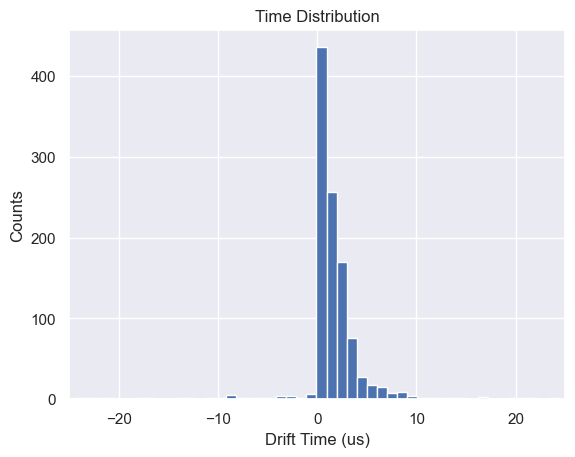

In [183]:
plt.hist([a for a in events_df['Drift_time'] if a > -1000], bins=200)
plt.title('Time Distribution')
plt.xlabel('Drift Time (us)')
plt.ylabel('Counts')
plt.xlim([-25, 25])
plt.show()

In [184]:
radii = calc_radius(events_df['Drift_time'])
Radius = pd.Series(data=radii, name='Radius')

events_df = pd.concat([events_df, Radius], axis=1)

In [187]:
events_df.head(20)

,Event,ID,Side,Layer,Column,R0,Trigger_time,Drift_time,Radius
0,0,0,1,0,7,847289447,847289131.5,4.21875,0.690353
1,0,1,1,8,0,847289127,847289131.5,0.21875,0.145422
2,0,2,1,5,3,847289197,847289131.5,1.09375,0.339242
3,0,3,1,6,2,847289122,847289131.5,0.15625,0.121821
4,0,4,1,1,7,847289281,847289131.5,2.14375,0.483425
5,0,5,1,1,6,847289437,847289131.5,4.09375,0.679510
6,0,6,1,7,1,847289134,847289131.5,0.30625,0.173596
7,0,7,1,4,4,847289144,847289131.5,0.43125,0.207864
8,0,8,1,0,8,847289316,847289131.5,2.58125,0.533064
9,0,9,1,6,60,847286043,847289131.5,-38.33125,NaN


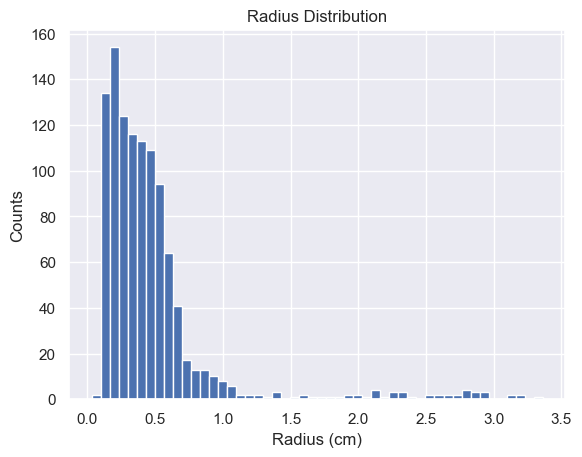

In [186]:
plt.hist(events_df['Radius'], bins=50)
plt.title('Radius Distribution')
plt.xlabel('Radius (cm)')
plt.ylabel('Counts')
plt.show()

In [135]:
len(events_df.index)

1296